multioutput LSTM model to predict filtered shear stress and TTF




In [ ]:
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt
import time
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from keras.models import Sequential, Model
from keras.optimizers import RMSprop, Adam
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Bidirectional, Input
from keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler
import h5py

In [ ]:
# Function to create data with timesteps
'''
def create_timesteps(data, n_steps):
  x = []
  y = []
  for i in range(len(data)):
    end_ix = i + n_steps
    if end_ix > len(data):
      break
    samps = np.arange(i,end_ix,10)
    x1, y1 = data[samps, :-2], data[samps[-1], -2:]  #last two columns is assumed to be the target variable
    x.append(x1)
    y.append(y1)
  return np.array(x), np.array(y)
'''
def create_timesteps(data, n_steps):
	x = []
	y = []
	for i in range(len(data)):
		end_ix = i + n_steps
		if end_ix > len(data):
			break
		x1, y1 = data[i:end_ix, :-2], data[end_ix-1, -2:]  #last two columns are assumed to be the target variable
		x.append(x1)
		y.append(y1)
	return np.array(x), np.array(y)


In [ ]:
# Load the data

data = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_ML_Master.mat')
m_t = pd.DataFrame({'Time':data['Time'].ravel().round(2), 'SS':data['SS'].ravel(), 'TTF':data['TTF'].ravel()})
a_t = pd.DataFrame({'Time':data['LocalAcTime'].ravel().round(2), 'V_filt':data['V_filt'].ravel(), 'Vel_pc':data['Vel_pc'].ravel()})  
df1 = a_t.merge(m_t, on='Time')

data2 = loadmat('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/data/p5270_run1_pp_wAmp.mat')
df2 = pd.DataFrame({'maxFreqI_filt':data2['maxFreqI_filt'][3786:136185].ravel(), 'freqQAmpI_filt':data2['freqQAmpI_filt'][3786:136185].ravel(),
                    'freqQAmpI_filt_pc':data2['freqQAmpI_filt_pc'].ravel()})

df = pd.concat([df1, df2], axis=1)

df = df[['freqQAmpI_filt', 'freqQAmpI_filt_pc', 'V_filt', 'Vel_pc', 'SS', 'TTF']]
print("Input data:\n", df)


Input data:
         freqQAmpI_filt  freqQAmpI_filt_pc       V_filt  Vel_pc        SS  TTF
0         31453.223522                0.0  5489.978529     0.0  5.656166  0.0
1         31438.277060                0.0  5489.981454     0.0  5.657157  0.0
2         31421.341616                0.0  5489.997639     0.0  5.658317  0.0
3         31409.798761                0.0  5490.007016     0.0  5.659499  0.0
4         31398.815589                0.0  5490.000189     0.0  5.660404  0.0
...                ...                ...          ...     ...       ...  ...
132394    31055.686766                0.0  5459.380488     0.0  5.471059  0.0
132395    31041.955345                0.0  5459.377762     0.0  5.474545  0.0
132396    31035.059531                0.0  5459.388352     0.0  5.478286  0.0
132397    31020.001291                0.0  5459.398820     0.0  5.481751  0.0
132398    31012.016780                0.0  5459.399041     0.0  5.484813  0.0

[132399 rows x 6 columns]


In [ ]:
# Preprocessing

arr = df.to_numpy()
n_steps = 60
xdf, ydf = create_timesteps(arr, n_steps)

print('Features shape, X = ', np.shape(xdf))
print('Target shape, Y = ', np.shape(ydf))

# Split into train-val-test
x_train, x_test, y_train, y_test = train_test_split(xdf, ydf, test_size=0.2, shuffle=False)
X_train, X_val, Y_train, Y_val = train_test_split(x_train, y_train, test_size=0.1, shuffle=False)

# Normalize the features
scaler = MinMaxScaler()
num_instances, num_time_steps, num_features = X_train.shape
X_train = scaler.fit_transform(np.reshape(X_train, (-1, num_features)))
X_train = np.reshape(X_train, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = X_val.shape
X_val = scaler.transform(np.reshape(X_val, (-1, num_features)))
X_val = np.reshape(X_val, (num_instances, num_time_steps, num_features))

num_instances, num_time_steps, num_features = x_test.shape
x_test = scaler.transform(np.reshape(x_test, (-1, num_features)))
x_test = np.reshape(x_test, (num_instances, num_time_steps, num_features))

print("Training:", np.shape(X_train))
print("Validation:", np.shape(X_val))
print("Testing:", np.shape(x_test))


Features shape, X =  (132340, 60, 4)
Target shape, Y =  (132340, 2)
Training: (95284, 60, 4)
Validation: (10588, 60, 4)
Testing: (26468, 60, 4)


Epoch 1/20
2978/2978 [==============================] - 269s 90ms/step - loss: 407.3539 - ss_loss: 345.5664 - ttf_loss: 123.5758 - val_loss: 4.3996 - val_ss_loss: 3.7156 - val_ttf_loss: 1.3679
Epoch 2/20
2978/2978 [==============================] - 278s 94ms/step - loss: 0.6795 - ss_loss: 0.2619 - ttf_loss: 0.8353 - val_loss: 0.1688 - val_ss_loss: 0.0163 - val_ttf_loss: 0.3050
Epoch 3/20
2978/2978 [==============================] - 273s 92ms/step - loss: 0.1161 - ss_loss: 0.0055 - ttf_loss: 0.2212 - val_loss: 0.1351 - val_ss_loss: 0.0106 - val_ttf_loss: 0.2491
Epoch 4/20
2978/2978 [==============================] - 271s 91ms/step - loss: 0.0867 - ss_loss: 0.0035 - ttf_loss: 0.1664 - val_loss: 0.1052 - val_ss_loss: 0.0029 - val_ttf_loss: 0.2046
Epoch 5/20
2978/2978 [==============================] - 272s 91ms/step - loss: 0.0787 - ss_loss: 0.0032 - ttf_loss: 0.1510 - val_loss: 0.0899 - val_ss_loss: 0.0017 - val_ttf_loss: 0.1766
Epoch 6/20
2978/2978 [==============================] - 273

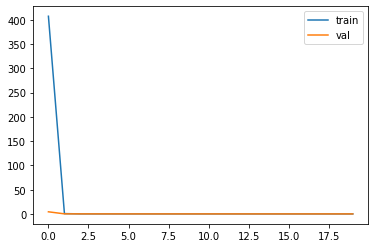

---Training time: 5427.80317307 seconds ---


In [ ]:
# Build the model

np.random.seed(0)   # To get reproducible results
#tf.random.set_seed(1)

out_dim = ydf.shape[1]

inp = Input(shape=(X_train.shape[1], X_train.shape[2]), name='inp')
m = LSTM(128, activation='relu', kernel_initializer='normal')(inp)
m = Dense(64, kernel_initializer='normal', activation='relu')(m)
ss = Dense(1, kernel_initializer='normal', activation='linear', name='ss')(m)
ttf = Dense(1, kernel_initializer='normal', activation='relu', name='ttf')(m)
model = Model(inputs=[inp], outputs=[ss,ttf])

losses = {'ss': 'mse', 'ttf':'mse'}
losswts = {'ss': 1.0, 'ttf': 0.5}

model.compile(loss=losses, loss_weights=losswts, optimizer='adam')

start_time = time.time()
history = model.fit(X_train, {'ss':Y_train[:,0], 'ttf':Y_train[:,1]}, epochs=20, batch_size=32, 
                    validation_data=(X_val, {'ss':Y_val[:,0], 'ttf':Y_val[:,1]}), verbose=1)
end_time = time.time()

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.show()

print("---Training time: %0.8f seconds ---" % (end_time - start_time))


In [ ]:
print(model.summary())
#model.save('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/models/LSTM_sstf.h5')

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp (InputLayer)                [(None, 60, 4)]      0                                            
__________________________________________________________________________________________________
lstm (LSTM)                     (None, 128)          68096       inp[0][0]                        
__________________________________________________________________________________________________
dense (Dense)                   (None, 64)           8256        lstm[0][0]                       
__________________________________________________________________________________________________
ss (Dense)                      (None, 1)            65          dense[0][0]                      
_______________________________________________________________________________________

In [ ]:
# Evaluate the model

y_predTrain = model.predict(X_train)
ss_train_r2 = r2_score(Y_train[:,0], y_predTrain[0])
ss_train_rmse = np.sqrt(mean_squared_error(Y_train[:,0], y_predTrain[0]))
ttf_train_r2 = r2_score(Y_train[:,1], y_predTrain[1])
ttf_train_rmse = np.sqrt(mean_squared_error(Y_train[:,1], y_predTrain[1]))

y_predVal = model.predict(X_val)
ss_val_r2 = r2_score(Y_val[:,0], y_predVal[0])
ss_val_rmse = np.sqrt(mean_squared_error(Y_val[:,0], y_predVal[0]))  
ttf_val_r2 = r2_score(Y_val[:,1], y_predVal[1])
ttf_val_rmse = np.sqrt(mean_squared_error(Y_val[:,1], y_predVal[1]))

start_time = time.time()
y_predTest = model.predict(x_test)
end_time = time.time()
ss_test_r2 = r2_score(y_test[:,0], y_predTest[0])
ss_test_rmse = np.sqrt(mean_squared_error(y_test[:,0], y_predTest[0]))
ttf_test_r2 = r2_score(y_test[:,1], y_predTest[1])
ttf_test_rmse = np.sqrt(mean_squared_error(y_test[:,1], y_predTest[1]))

print("Shear Stress\nR2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ss_train_r2, ss_val_r2, ss_test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ss_train_rmse, ss_val_rmse, ss_test_rmse))

print("\nTTF\nR2 scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ttf_train_r2, ttf_val_r2, ttf_test_r2))
print("RMSE scores: Train - %0.5f, Validation - %0.5f, Test - %0.5f" %(ttf_train_rmse, ttf_val_rmse, ttf_test_rmse))

print("\n---Time for Test data prediction: %0.8f seconds ---" % (end_time - start_time))


Shear Stress
R2 scores: Train - 0.94689, Validation - 0.96447, Test - 0.93210
RMSE scores: Train - 0.02963, Validation - 0.02760, Test - 0.03773

TTF
R2 scores: Train - 0.93387, Validation - 0.92713, Test - 0.86065
RMSE scores: Train - 0.26984, Validation - 0.30917, Test - 0.42924

---Time for Test data prediction: 6.23433971 seconds ---


Text(0.5, 1.0, 'Time to Failure prediction using multioutput LSTM model')

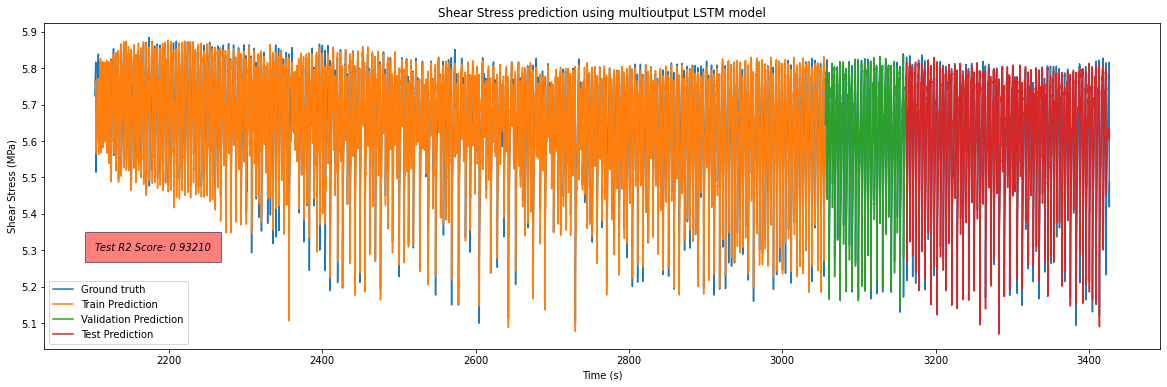

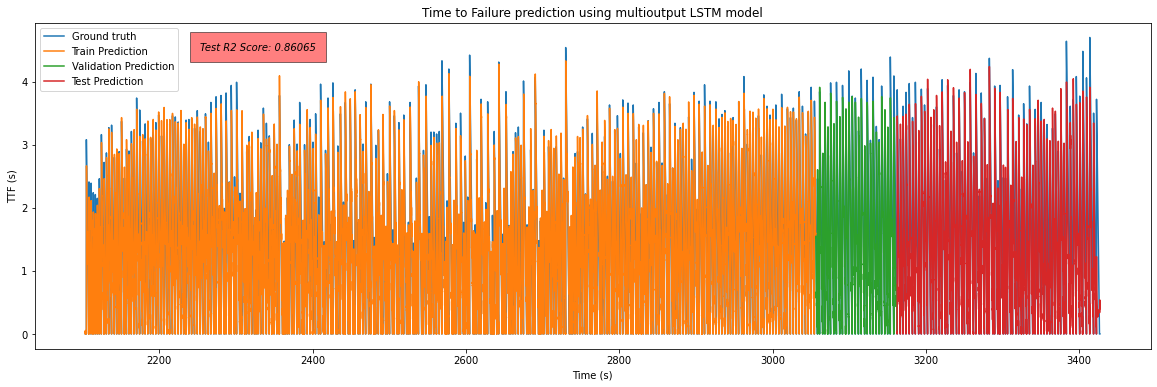

In [ ]:
# Overall plots


ttime = df1['Time'][n_steps-1:]
t1, testtime = train_test_split(ttime, test_size=0.2, shuffle=False)
traintime, valtime = train_test_split(t1, test_size=0.1, shuffle=False)

## SS
fig = plt.figure(1, figsize=(20,6))
plt.plot(ttime, ydf[:,0])
plt.plot(traintime, y_predTrain[0])
plt.plot(valtime, y_predVal[0])
plt.plot(testtime, y_predTest[0])
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.text(ttime.iloc[0], 5.3, 'Test R2 Score: %0.5f' %(ss_test_r2), style='italic', bbox=dict(facecolor='red', alpha=0.5, pad=10))
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('Shear Stress prediction using multioutput LSTM model')

## TTF
fig = plt.figure(2, figsize=(20,6))
plt.plot(ttime, ydf[:,1])
plt.plot(traintime, y_predTrain[1])
plt.plot(valtime, y_predVal[1])
plt.plot(testtime, y_predTest[1])
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.text(ttime.iloc[15000], 4.5, 'Test R2 Score: %0.5f' %(ttf_test_r2), style='italic', bbox=dict(facecolor='red', alpha=0.5, pad=10))
plt.legend(['Ground truth', 'Train Prediction', 'Validation Prediction', 'Test Prediction'])
plt.title('Time to Failure prediction using multioutput LSTM model')


In [ ]:
# Save
'''
hf = h5py.File('/content/drive/My Drive/Colab Notebooks/Labquake_prediction/MLpreprocessed_code/predictions/lstm_mo2.h5', 'w')
g1 = hf.create_group('ss')
g1.create_dataset('y_predTrain', data=y_predTrain[0])
g1.create_dataset('y_predVal', data=y_predVal[0])
g1.create_dataset('y_predTest', data=y_predTest[0])

g2 = hf.create_group('ttf')
g2.create_dataset('y_predTrain', data=y_predTrain[1])
g2.create_dataset('y_predVal', data=y_predVal[1])
g2.create_dataset('y_predTest', data=y_predTest[1])
hf.close()
'''

In [ ]:
# Results plot
'''
def results_plot(fig_no, gt, pred, title, ylabel):
  fig = plt.figure(fig_no, figsize=(20,6))
  plt.plot(gt)
  plt.plot(pred)
  plt.xlabel('Samples')
  plt.ylabel(ylabel)
  plt.legend(['Ground truth', 'Predicted'])
  plt.title(title)

results_plot(1, Y_train[:,0], y_predTrain[0], 'Training data', 'Shear Stress')
results_plot(2, Y_val[:,0], y_predVal[0], 'Validation data', 'Shear Stress')
results_plot(3, y_test[:,0], y_predTest[0], 'Testing data', 'Shear Stress')
results_plot(4, Y_train[:,1], y_predTrain[1], 'Training data', 'TTF')
results_plot(5, Y_val[:,1], y_predVal[1], 'Validation data', 'TTF')
results_plot(6, y_test[:,1], y_predTest[1], 'Testing data', 'TTF')
'''


Text(0.5, 1.0, 'Detailed View, Testing Data')

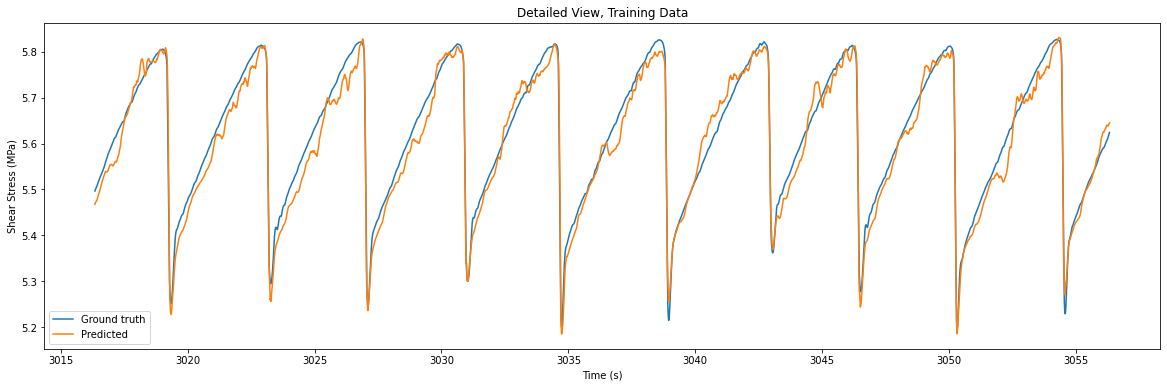

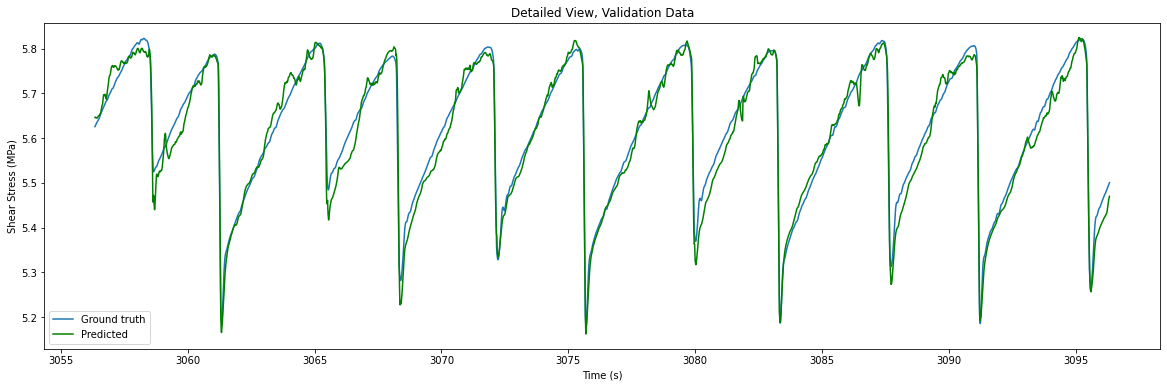

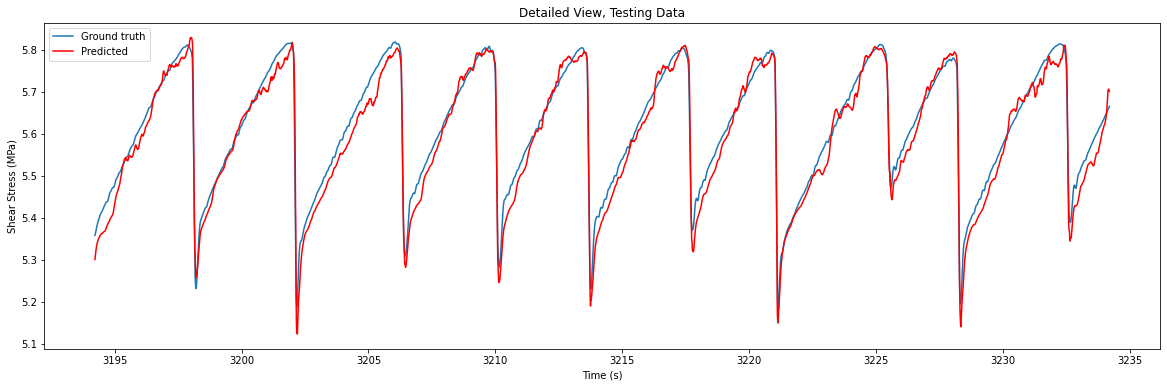

In [ ]:
# Detailed view of the plots

n=4000

fig = plt.figure(4, figsize=(20,6))
plt.plot(traintime[-n:], Y_train[-n:,0])
plt.plot(traintime[-n:], y_predTrain[0][-n:])
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(valtime[:n], Y_val[:n,0])
plt.plot(valtime[:n], y_predVal[0][:n], 'g')
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Validation Data')

st_i = 3200
fig = plt.figure(6, figsize=(20,6))
plt.plot(testtime[st_i:st_i+n], y_test[st_i:st_i+n,0])
plt.plot(testtime[st_i:st_i+n], y_predTest[0][st_i:st_i+n], 'r')
plt.xlabel('Time (s)')
plt.ylabel('Shear Stress (MPa)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')


Text(0.5, 1.0, 'Detailed View, Testing Data')

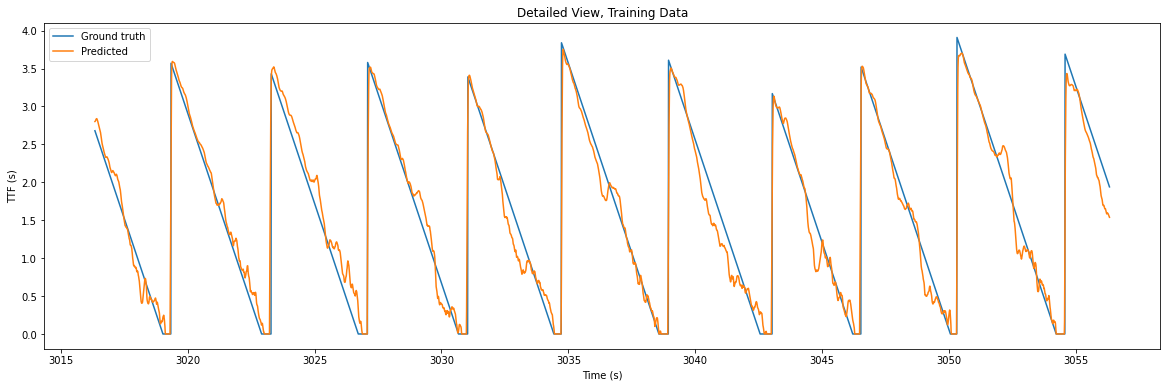

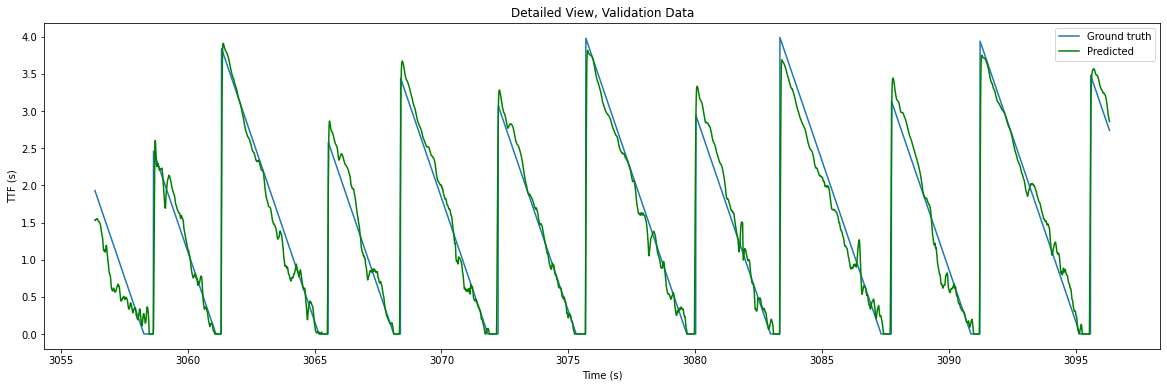

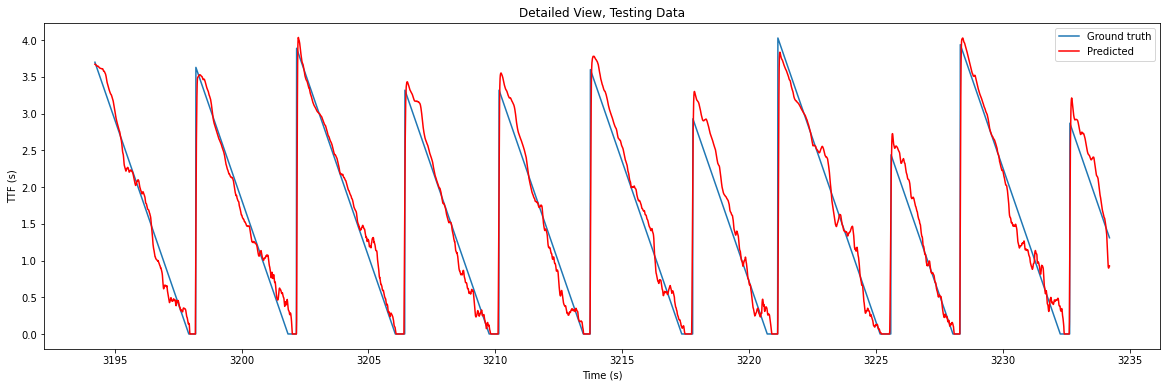

In [ ]:
# Detailed view of the plots

n=4000

fig = plt.figure(4, figsize=(20,6))
plt.plot(traintime[-n:], Y_train[-n:,1])
plt.plot(traintime[-n:], y_predTrain[1][-n:])
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Training Data')

fig = plt.figure(5, figsize=(20,6))
plt.plot(valtime[:n], Y_val[:n,1])
plt.plot(valtime[:n], y_predVal[1][:n], 'g')
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Validation Data')

st_i = 3200
fig = plt.figure(6, figsize=(20,6))
plt.plot(testtime[st_i:st_i+n], y_test[st_i:st_i+n,1])
plt.plot(testtime[st_i:st_i+n], y_predTest[1][st_i:st_i+n], 'r')
plt.xlabel('Time (s)')
plt.ylabel('TTF (s)')
plt.legend(['Ground truth', 'Predicted'])
plt.title('Detailed View, Testing Data')


Text(0.5, 1.0, 'TTF')

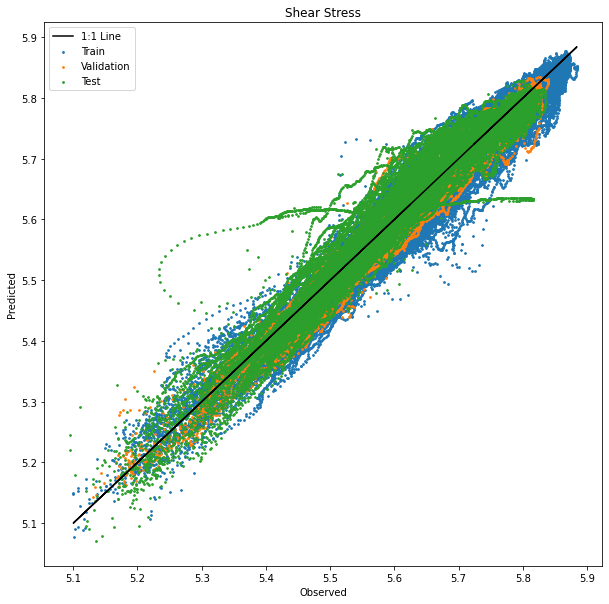

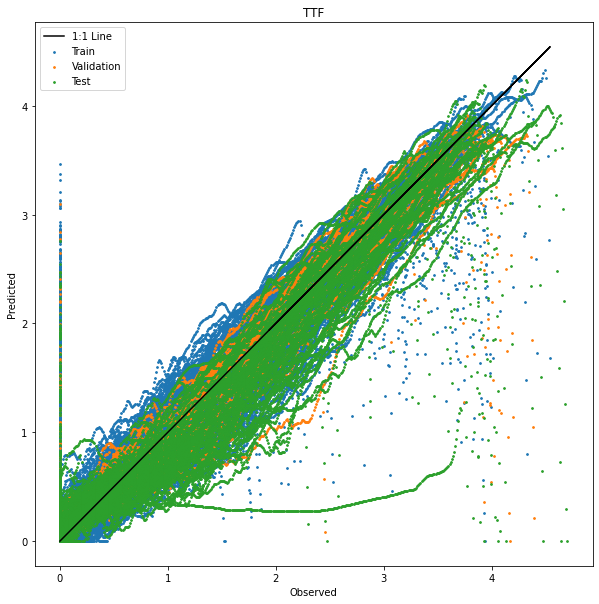

In [ ]:
# Regression analysis
fig = plt.figure(7, figsize=(10,10))
plt.plot(Y_train[:,0], Y_train[:,0], 'black')
plt.scatter(Y_train[:,0], y_predTrain[0], s=3)
plt.scatter(Y_val[:,0], y_predVal[0], s=3)
plt.scatter(y_test[:,0], y_predTest[0], s=3)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(['1:1 Line','Train', 'Validation', 'Test'])
plt.title('Shear Stress')

fig = plt.figure(8, figsize=(10,10))
plt.plot(Y_train[:,1], Y_train[:,1], 'black')
plt.scatter(Y_train[:,1], y_predTrain[1], s=3)
plt.scatter(Y_val[:,1], y_predVal[1], s=3)
plt.scatter(y_test[:,1], y_predTest[1], s=3)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.legend(['1:1 Line','Train', 'Validation', 'Test'])
plt.title('TTF')

